<a href="https://www.kaggle.com/code/jenntm/gcce-catvsdog-dic-22?scriptVersionId=118378191" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Cats vs. Dogs Class dataset for multiple annotators


## Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# os.chdir('/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Notebooks')
# cwd = os.getcwd()
# sys.path.append("../Models")


# from Multiple_Annotators_C import MultipleAnnotators_Classification

#import sys
#sys.path.insert(1, '../input/multiple-annotators-c/')
#os.chdir('/Multiple Anotators-c/')
#cwd = os.getcwd()
#sys.path.append('/input/multiple-annotators-c')
#from Multiple_Annotators_C import MultipleAnnotators_Classification

# seed_value= 12321 
# from numpy.random import seed
# seed(seed_value)
# tf.random.set_seed(seed_value)

## Download and Prepare the Dataset

We will use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and we can load it via Tensorflow Datasets. The images are labeled 0 for cats and 1 for dogs.

# Multiple annotators model

In [4]:

validation_data = tf.data.experimental.load('/kaggle/input/catsvsdog-ma/cats_dogs_Te')
train_data_MA = tf.data.experimental.load('/kaggle/input/catsvsdog-ma/cats_dogs_MA_Tr_1')



2023-02-06 14:27:20.232166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 14:27:20.373332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 14:27:20.374074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 14:27:20.375594: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
image_count = tf.data.experimental.cardinality(train_data_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count

18610

In [6]:
image_count1 = tf.data.experimental.cardinality(validation_data).numpy() # los datos de training son 18610
image_count1

4652

In [7]:
#X_test = [validation_data[i][0] for i in range(image_count1)]
#Y_true_test = [validation_data[i][1] for i in range(image_count1)]
#Y_true_test = np.asarray([aux[1].numpy() for aux  in validation_data])
#X_test = np.asarray([aux[0].numpy() for aux  in validation_data])

In [8]:
image_count

18610

In [9]:
val_size = int(image_count * 0.2)
train_ds_MA = train_data_MA.skip(val_size)
val_ds_MA = train_data_MA.take(val_size)

In [10]:
batch_size = 100
train_batches_MA = train_ds_MA.shuffle(1024).batch(batch_size)
val_batches_MA = val_ds_MA.shuffle(1024).batch(batch_size)
test_batches_MA = validation_data.shuffle(1024).batch(batch_size)

In [11]:
image_count = tf.data.experimental.cardinality(train_ds_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count

14888

In [12]:
image_count_val = tf.data.experimental.cardinality(val_ds_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count_val

3722

2023-02-06 14:27:23.833989: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 14:27:36.230144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1024
2023-02-06 14:27:39.935262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


annotator 1
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        62
           1       0.59      0.68      0.63        38

    accuracy                           0.70       100
   macro avg       0.69      0.70      0.69       100
weighted avg       0.71      0.70      0.70       100

annotator 2
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        62
           1       0.79      0.87      0.82        38

    accuracy                           0.86       100
   macro avg       0.85      0.86      0.85       100
weighted avg       0.87      0.86      0.86       100

annotator 3
              precision    recall  f1-score   support

           0       0.82      0.50      0.62        62
           1       0.50      0.82      0.62        38

    accuracy                           0.62       100
   macro avg       0.66      0.66      0.62       100
weighted avg       0.70      0.62     

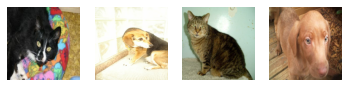

In [13]:
from sklearn.metrics import classification_report
i = 0
fig, ax = plt.subplots(1, 4)
for image, label, label2 in train_batches_MA.take(4):
   # predictedLabel = int(predictions[i] >= 0.5)
   # print(label2)
    ax[i].axis('off')
   # ax[i].set_title(classNames[label[i]])
    ax[i].imshow(image[0])
    i += 1
    for j in range(label2.shape[1]):
      print('annotator',j+1)
      print(classification_report(label ,label2[:,j]))
plt.show()

## Build the classifier from multiple annotators

In [14]:
import tensorflow_datasets as tfds
import tensorflow as tf
import time
from tensorflow.keras import regularizers

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model

class MultipleAnnotators_Classification():
    def __init__(self, output_dim, num_annotators, q= 0.0001):
        self.K = output_dim
        self.R = num_annotators
        self.q = q
        #self.callbacks #=callbacks
        #self.l1_param=l1_param 
        #self.l2_param=l1_param

    def CrowdLayer(self, input):
       #x = keras.layers.Dense(self.R + self.K,  ,  activation='tanh')(input)
        output_cla = keras.layers.Dense(self.K,    activation='softmax')(input)
        output_ann = keras.layers.Dense(self.R, activation='sigmoid')(input)
        output = keras.layers.Concatenate()([output_cla, output_ann])
        
        return output
#RCDNN   
#     def loss(self):
#         def custom_loss(y_true, y_pred):
#             # print(y_true,y_pred)
#             pred = y_pred[:, :self.K]
#             pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
#             ann_ = y_pred[:, self.K:]
#             Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
#             Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
#             p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
#             temp1 = ann_*tf.math.log(p_logreg)  
#             temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
#             # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
#             # print(tf.reduce_mean(Y_true,axis=1).numpy())
#             return -tf.math.reduce_sum((temp1 + temp2))
#         return custom_loss
    
    def loss(self):
        def custom_loss(y_true, y_pred):
               # print(y_true,y_pred)
           # q = 0.1
            pred = y_pred[:, :self.K]
            pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
            ann_ = y_pred[:, self.K:]
            # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
            Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
            Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

            p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
            temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
            temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
            return tf.math.reduce_sum((temp1 + temp2))
        return custom_loss

    @tf.function
    def train_step(self, x, Y, y):
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss_value = self.loss_fn(Y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, logits[:, :self.K])
        return loss_value

    @tf.function
    def test_step(self, x, y):
        val_logits = self.model(x, training=False)
        self.val_acc_metric.update_state(y, val_logits[:,:self.K])

    def fit(self, model, Data_tr, Data_Val, epochs):
        self.model = model
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Instantiate an optimizer.
        self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
        #self.optimizer =  tf.keras.optimizers.Adam(learning_rate=1e-3)
        #self.optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, clipnorm=1.0)
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Instantiate a loss function.
        self.loss_fn = self.loss()
        self.train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
        self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

        train_loss = np.zeros(epochs)
        train_accur = np.zeros(epochs)
        val_accur = np.zeros(epochs)
        val_loss = np.zeros(epochs)

        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train, Y_batch_train) in enumerate(Data_tr):
                # print(y_batch_train, Y_batch_train)
                loss_value = self.train_step(x_batch_train, Y_batch_train, y_batch_train)

                # Log every 200 batches.
                if step % 10 == 0:
                    train_acc = self.train_acc_metric.result()
                    print(
                      "Training loss (for one batch) at step %d: %.4f, Accuracy: %.4f"
                      % (step, float(loss_value), float(train_acc))
                            )
                # print("Seen so far: %d samples" % ((step + 1) * batch_size))



            # Run a validation loop at the end of each epoch.
            for x_batch_val, y_batch_val,Y_batch_val in Data_Val:

                val_logits = model(x_batch_val, training=False)

                val_loss_value = self.loss_fn(Y_batch_val, val_logits)

                self.val_acc_metric.update_state(y_batch_val, val_logits[:,:self.K])
                
               # np.round(np.mean([model(x_batch_val, training= True) for sample in range(100)]), 2)


             # Display metrics at the end of each epoch.
            train_acc = self.train_acc_metric.result()
            val_acc = self.val_acc_metric.result()


            print('---- Training ----')
            print("Training loss: %.4f" % (float(loss_value),))
            print("Training acc over epoch: %.4f" % (float(train_acc),))
            # Reset training metrics at the end of each epoch
            self.train_acc_metric.reset_states()
            self.val_acc_metric.reset_states()


            train_loss[epoch] = float(loss_value)
            train_accur[epoch] = float(train_acc)

            val_accur[epoch] = float(val_acc)
            val_loss[epoch] = float(val_loss_value) 


            print('---- Validation ----')
            print("Validation loss: %.4f" % (float(val_loss_value),))
            print("Validation acc: %.4f" % (float(val_acc),))

            print("Time taken: %.2fs" % (time.time() - start_time))

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Loss and accuracy')
        ax1.plot(range(1,epochs+1),train_loss)
        ax1.plot(range(1,epochs+1), val_loss)
        ax2.plot(range(1,epochs+1),train_accur)
        ax2.plot(range(1,epochs+1),val_accur)
        #plt.figure(figsize=(16,9))
        ax1.set(xlabel= 'Epoch', ylabel="Loss")
        ax2.set(xlabel= 'Epoch',ylabel="Accuracy")
        ax1.legend(['Training_loss', 'Validation_loss'])
        ax2.legend(['Training', 'Validation'])
        ax1.grid()
        ax2.grid()
        plt.show()
        return self.model

    def eval_model(self, Data):
        self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
        for x_batch_val, y_batch_val in Data:
            self.test_step(x_batch_val, y_batch_val)

        val_acc = self.val_acc_metric.result()
        self.val_acc_metric.reset_states()
        return val_acc






In [15]:
def custom_loss(y_true, y_pred):
  # print(y_true,y_pred)
  K = 2 #len(np.unique(y_true))
  R = 5
  q = 0.1
  pred = y_pred[:, K]
  pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
  ann_ = y_pred[:,  K:]
  # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
  Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=K, axis=1)
  Y_hat = tf.repeat(tf.expand_dims(pred,-1), R, axis = -1)

  p_gcce = Y_true*(1 - Y_hat**q)/q
  temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
  temp2 = (1 - ann_)*(1-(1/K)**q)/q*tf.reduce_sum(Y_true,axis=1)
  return tf.math.reduce_sum((temp1 + temp2))



In [16]:
MA = MultipleAnnotators_Classification(2, 5, 0.001)
 
def create_model():
   
    l1 = 1e-2
    # Block 1
    inputs = keras.layers.Input(shape=(150, 150, 3), name='entrada')
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.Conv2D(32, (3, 3), activation="relu" , name="block1_conv1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)


    # Block 2
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, (3, 3), activation="relu", name="block2_conv1")(x)
    x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)

    # Block 3
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation="relu", name="block3_conv1" )(x)             
    x = keras.layers.BatchNormalization()(x)
   # x = keras.layers.Dropout(0.2)(x)
   
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)
    
    # Block 4
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation="relu", name="block4_conv1")(x)            
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)
    #x = keras.layers.Dropout(0.2)(x)
    
    #x = keras.layers.GlobalAveragePooling2D()(x)
   
    x = keras.layers.Flatten()(x)
    #x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    output = MA.CrowdLayer(x)
    model = keras.Model(inputs=inputs,outputs=output)

    return model
  
  


Start of epoch 0


2023-02-06 14:27:45.878071: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Training loss (for one batch) at step 0: 499.8174, Accuracy: 0.5300
Training loss (for one batch) at step 10: 417.3527, Accuracy: 0.5709
Training loss (for one batch) at step 20: 495.1985, Accuracy: 0.5562
Training loss (for one batch) at step 30: 517.4245, Accuracy: 0.5565
Training loss (for one batch) at step 40: 436.8000, Accuracy: 0.5532
Training loss (for one batch) at step 50: 433.8491, Accuracy: 0.5480
Training loss (for one batch) at step 60: 427.1490, Accuracy: 0.5551
Training loss (for one batch) at step 70: 437.3154, Accuracy: 0.5549
Training loss (for one batch) at step 80: 434.5520, Accuracy: 0.5537
Training loss (for one batch) at step 90: 485.1485, Accuracy: 0.5529
Training loss (for one batch) at step 100: 423.8014, Accuracy: 0.5553
Training loss (for one batch) at step 110: 421.6901, Accuracy: 0.5586
Training loss (for one batch) at step 120: 448.2731, Accuracy: 0.5621
Training loss (for one batch) at step 130: 414.9524, Accuracy: 0.5627
Training loss (for one batch) a

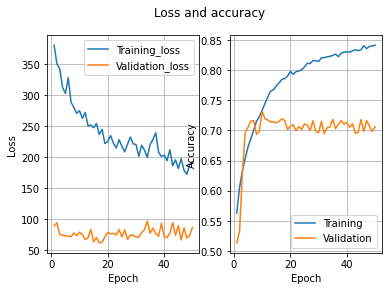

===== Q: 0.0001
Validation acc: 0.7395
Validation AUC: 0.7363
Validation Balanced_ACC: 0.4715
Validation MI: 0.1398
Validation Normalized MI: 0.2118
Validation Adjusted MI: 0.2118

Start of epoch 0
Training loss (for one batch) at step 0: 505.7479, Accuracy: 0.5400
Training loss (for one batch) at step 10: 447.0490, Accuracy: 0.5209
Training loss (for one batch) at step 20: 451.4684, Accuracy: 0.5319
Training loss (for one batch) at step 30: 446.2194, Accuracy: 0.5390
Training loss (for one batch) at step 40: 465.4218, Accuracy: 0.5424
Training loss (for one batch) at step 50: 433.5737, Accuracy: 0.5516
Training loss (for one batch) at step 60: 414.4743, Accuracy: 0.5607
Training loss (for one batch) at step 70: 417.3436, Accuracy: 0.5624
Training loss (for one batch) at step 80: 393.9321, Accuracy: 0.5642
Training loss (for one batch) at step 90: 431.9925, Accuracy: 0.5688
Training loss (for one batch) at step 100: 429.0975, Accuracy: 0.5686
Training loss (for one batch) at step 110: 

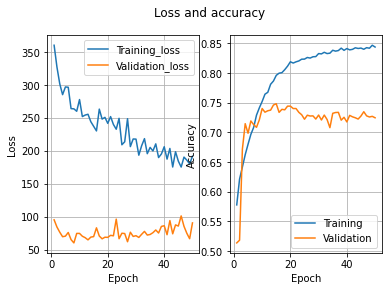

===== Q: 0.0001
Validation acc: 0.7416
Validation AUC: 0.7390
Validation Balanced_ACC: 0.4764
Validation MI: 0.1395
Validation Normalized MI: 0.2098
Validation Adjusted MI: 0.2098

Start of epoch 0
Training loss (for one batch) at step 0: 523.5577, Accuracy: 0.4400
Training loss (for one batch) at step 10: 496.8537, Accuracy: 0.5073
Training loss (for one batch) at step 20: 413.1437, Accuracy: 0.5348
Training loss (for one batch) at step 30: 398.0397, Accuracy: 0.5400
Training loss (for one batch) at step 40: 416.8891, Accuracy: 0.5463
Training loss (for one batch) at step 50: 397.8508, Accuracy: 0.5473
Training loss (for one batch) at step 60: 450.8154, Accuracy: 0.5510
Training loss (for one batch) at step 70: 439.6840, Accuracy: 0.5568
Training loss (for one batch) at step 80: 427.2680, Accuracy: 0.5595
Training loss (for one batch) at step 90: 430.2664, Accuracy: 0.5634
Training loss (for one batch) at step 100: 416.2726, Accuracy: 0.5672
Training loss (for one batch) at step 110: 

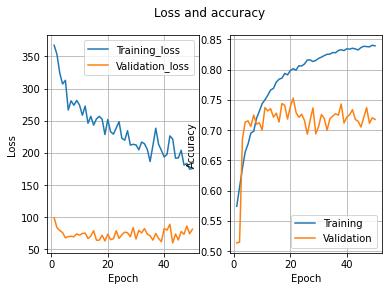

===== Q: 0.0001
Validation acc: 0.7347
Validation AUC: 0.7317
Validation Balanced_ACC: 0.4720
Validation MI: 0.1369
Validation Normalized MI: 0.2060
Validation Adjusted MI: 0.2060

Start of epoch 0
Training loss (for one batch) at step 0: 477.0761, Accuracy: 0.5800
Training loss (for one batch) at step 10: 506.3525, Accuracy: 0.5173
Training loss (for one batch) at step 20: 487.0284, Accuracy: 0.5467
Training loss (for one batch) at step 30: 473.9713, Accuracy: 0.5361
Training loss (for one batch) at step 40: 449.3256, Accuracy: 0.5402
Training loss (for one batch) at step 50: 453.2224, Accuracy: 0.5414
Training loss (for one batch) at step 60: 443.9537, Accuracy: 0.5470
Training loss (for one batch) at step 70: 440.9017, Accuracy: 0.5532
Training loss (for one batch) at step 80: 439.6539, Accuracy: 0.5572
Training loss (for one batch) at step 90: 437.2178, Accuracy: 0.5582
Training loss (for one batch) at step 100: 482.1266, Accuracy: 0.5590
Training loss (for one batch) at step 110: 

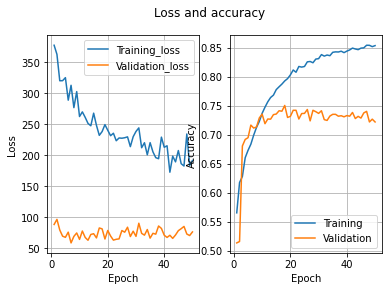

===== Q: 0.0001
Validation acc: 0.7309
Validation AUC: 0.7279
Validation Balanced_ACC: 0.4680
Validation MI: 0.1339
Validation Normalized MI: 0.2013
Validation Adjusted MI: 0.2013

Start of epoch 0
Training loss (for one batch) at step 0: 494.2982, Accuracy: 0.6100
Training loss (for one batch) at step 10: 429.1270, Accuracy: 0.5264
Training loss (for one batch) at step 20: 467.7954, Accuracy: 0.5367
Training loss (for one batch) at step 30: 470.4799, Accuracy: 0.5413
Training loss (for one batch) at step 40: 469.8508, Accuracy: 0.5437
Training loss (for one batch) at step 50: 441.4360, Accuracy: 0.5469
Training loss (for one batch) at step 60: 458.9110, Accuracy: 0.5500
Training loss (for one batch) at step 70: 453.5223, Accuracy: 0.5530
Training loss (for one batch) at step 80: 445.4177, Accuracy: 0.5548
Training loss (for one batch) at step 90: 399.2392, Accuracy: 0.5544
Training loss (for one batch) at step 100: 440.9690, Accuracy: 0.5559
Training loss (for one batch) at step 110: 

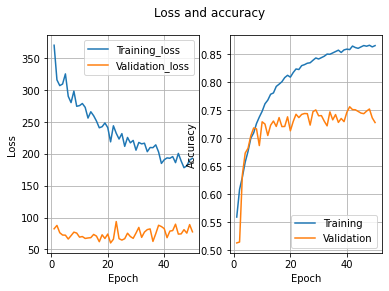

===== Q: 0.0001
Validation acc: 0.7334
Validation AUC: 0.7304
Validation Balanced_ACC: 0.4663
Validation MI: 0.1334
Validation Normalized MI: 0.2009
Validation Adjusted MI: 0.2009


In [17]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
#model = create_model()
K=2
R=5
val_q = [0.0001]   #0.2, 0.4, 0.6, 0.8]
NUM_RUNS = 5
N_EPOCHS = 50 
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
BACC1 = []
MI1 = []
NMI1 =[]
AMI1 = []
val_acc = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS):
  MA = MultipleAnnotators_Classification(2, 5, val_q[0])
  model =  create_model()
  model = MA.fit(model, train_batches_MA, val_batches_MA, N_EPOCHS)
  #model = MA.fit(model, Data_train_MA, N_EPOCHS)
  ACC[i] = MA.eval_model(test_batches_MA)
  print("===== Q: %.4f" % (float(val_q[0]),))
  print("Validation acc: %.4f" % (float(ACC[i]),))


    #AUC =======================
  val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
  for x_batch_val, y_batch_val in test_batches_MA:
      val_logits = model(x_batch_val.numpy(), training=False)
      # tf.print(y_batch_val)
      val_AUC_metric.update_state(y_batch_val, val_logits[:,:K].numpy().argmax(axis=1).astype('float'))   #val_logits[:,Y.shape[1]:].argmax(axis=1).astype('float'))
      BACC1.append(balanced_accuracy_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True))
      MI1.append(mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
      NMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
      AMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))

  val_AUC = val_AUC_metric.result()
  val_AUC_metric.reset_states()
  val_AUC = val_AUC.numpy()
  print("Validation AUC: %.4f" % (float(val_AUC),))
  AUC[i] = val_AUC
  #===================================================
    
  # balanced. Accurcy
  BACC[i] = np.array(BACC1).mean() # balanced_accuracy_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True)
  print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

  #MI
  
  MI[i] =  np.array(MI1).mean()  #mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
  print("Validation MI: %.4f" % (float(MI[i]),))
  NMI[i] =  np.array(NMI1).mean()   #normalized_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
  print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
  AMI[i]= np.array(AMI1).mean()  #adjusted_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
  print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))

    
import pandas as pd
df = pd.DataFrame(ACC)
#df.to_csv('/content/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output

In [18]:
# classification_report_r= []
# model = create_model()
# K=2
# R=5
# NUM_RUNS = 10
# N_EPOCHS = 30
# val_acc = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS):
#   MA = MultipleAnnotators_Classification(K, R, 0.1)
#   model = create_model()
#   optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
#   model.compile(optimizer=optimizer, loss= MA.loss())
#   history_model = model.fit(train_batches_MA, validation_data=val_batches_MA, epochs= N_EPOCHS, callbacks=callbacks, verbose=0)
#   #model = MA.fit(model, Data_train_MA, N_EPOCHS)
#   pred_2 = model.predict(X_test)

#   lambda_R_ = pred_2[:, K:] #annotators reliability prediction N x R   
#   classification_report_r += [classification_report( pred_2[:,:K].argmax(axis=1),Y_true_test.ravel(),output_dict=True)]
#   print(classification_report( pred_2[:,:K].argmax(axis=1),Y_true_test.ravel()))
#   #val_acc[i] = MA.eval_model(test_batches_MA)
#   #print("Validation acc: %.4f" % (float(val_acc[i]),))
#   # Create the history figure
#   plt.figure(figsize=(16,9))
#   for i in  history_model.history:
#       plt.plot(history_model.history[i],label=i)
#   plt.title('Model history')
#   plt.legend()
#   plt.grid()

# import pandas as pd
# df = pd.DataFrame(val_acc)
# #df.to_csimport pandas as pddf = pd.DataFrame(val_acc)#df.to_csv('/kaggle/working/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output​v('/kaggle/working/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output


In [19]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  73.6
Average std:  0.38999999999999996
Average AUC:  73.31
Average AUC std:  0.4
Average Balanced Accuracy:  47.08
Average std:  0.35000000000000003
Average MI:  13.669999999999998
Average std:  0.27
Average Normalized MI:  20.599999999999998
Average std:  0.44
Average Ajdusted MI:  20.599999999999998
Average std:  0.44
